# Likelihood function, Test statistics, and Asymptotic approximation

ref[1]: https://arxiv.org/pdf/1007.1727.pdf

In [97]:
import numpy as np
from scipy.stats import poisson
from scipy.special import factorial
from scipy.stats import norm
from scipy import integrate
import matplotlib.pyplot as plt
import time
import pandas as pd
import uproot

In [98]:
# input folder
filepath_prefix = "samples/ntuples-VBF-ANA-mc1516-"

# collect data of each process
processes = ['ggF', 'VBF', 'top', 'WW', 'Zjets']
columns = ['weight', 'event_number', 'MT', 'Mll', 'Mjj', 'N_bjets', 'm_tautau', 'mZ', 'OLV', 'centralJetVetoLeadpT', 'lep0_flavour', 'lep1_flavour', 'dilepton_charge']

mcData = []
for i in range(len(processes)):
    file = uproot.open(filepath_prefix + processes[i] + ".root")
    df = file['observables'].arrays(columns, library="pd")
    df['process'] = [processes[i] for evt in range(len(df))] # add a column to label each event
    mcData.append(df)

mcData = pd.concat(mcData, ignore_index=True)

In [99]:
file = uproot.open("samples/ntuple-VBF-ANA-data1516.root")
realData = file['observables'].arrays(columns, library="pd")
realData['process'] = ['data' for evt in range(len(realData))] #actual data from detector?

In [100]:
def SR_selections(dataset): #define a function to apply signal region cuts to dataset
    
    dataset_VBFSR = dataset[(dataset['OLV']==1)& (dataset['centralJetVetoLeadpT']<30000)\
                            & (dataset['N_bjets']==0)\
                            & (dataset['m_tautau'] < dataset['mZ']-25)\
                            & (dataset['centralJetVetoLeadpT']/1000. < 30)\
                            & (dataset['OLV'] == 1.)\
                            & (dataset['Mjj'] > 120.)]
    return dataset_VBFSR

In [101]:
def CR_selections(dataset): #define a function to apply signal region cuts to dataset
    
    dataset_VBFCR = dataset[(dataset['N_bjets']==1)\
                            & (dataset['m_tautau'] < dataset['mZ']-25)\
                            & (dataset['centralJetVetoLeadpT']/1000. < 30)\
                            & (dataset['OLV'] == 1.)]
    return dataset_VBFCR

### Step 1: Build the Likelihood function

For simplicity, in the following we only consider the VBF SR and the top CR. (also neglect signal contamination in top CR).

n: number of total observed events in SR

m: number of total observed events in CR

s: number of signal events in SR

b: number of bkg events in SR

$\mu$: signal strength of signal

$\tau$: = (b_CR)/(b_SR)


$$Poisson(SR) = \frac{(\mu s+b)^n}{n!}e^{-(\mu s+b)}$$

$$Poisson(CR) = \frac{(\tau b)^m}{m!}e^{-\tau b}$$

$$L = Poisson(SR) \times Poisson(CR)$$

In [102]:
#######################################
# Code 1: Build the Likelihood function 
#######################################

def likelihood(mu,s,b,tau,n,m):
    """
    mu: signal strength
    s: # of expected signal events
    b: # of expected background events
    tau: = b_cr/b_sr
    n: # of observed events in SR
    m: # of observed events in CR
    """
    
    L1 = poisson.pmf(n, mu*s+b)
    L2 = poisson.pmf(m, tau*b)
    
    return L1*L2

In [103]:
mc_VBFSR = SR_selections(mcData)
realdata_VBFSR = SR_selections(realData)
mc_VBFCR = CR_selections(mcData)
realdata_VBFCR = CR_selections(realData)
print('mc_VBFSR: '+format(len(mc_VBFSR)))
print('realdata_VBFSR: '+format(len(realdata_VBFSR)))
print('mc_VBFCR: '+format(len(mc_VBFCR)))
print('realdata_VBFCR: '+format(len(realdata_VBFCR)))

mc_VBFSR: 180676
realdata_VBFSR: 3051
mc_VBFCR: 282036
realdata_VBFCR: 11238


In [104]:
nn_obs = len(realdata_VBFSR)
nn_mc = round(np.sum(mc_VBFSR['weight']))
#sum all event weight from every MC samples (after SR cut)
S_MC = round(np.sum(mc_VBFSR[mc_VBFSR['process']=='VBF']['weight']))
S_DATA = round(np.sum(realdata_VBFSR[realdata_VBFSR['process']=='VBF']['weight']))
#sum all event weight from every VBF sample (after SR cut)
B_MC = round(np.sum(mc_VBFSR['weight']) - S_MC)
B_DATA = round(np.sum(realdata_VBFSR['weight']) - S_DATA)
#sum of all event weight, excluding VBF sample with SR cut applied
print("SR")
print("n_obs: {}, n_mc: {}, s_mc: {}, b_mc: {}, s_data: {}, b_data: {}".format(nn_obs, nn_mc, S_MC, B_MC, S_DATA, B_DATA))

SR
n_obs: 3051, n_mc: 2961, s_mc: 56, b_mc: 2905, s_data: 0, b_data: 3051


In [105]:
nn_obs_CR = len(realdata_VBFCR)
nn_mc_CR = round(np.sum(mc_VBFCR['weight']))
#sum all event weight from every MC samples (after SR cut)
S_MC_CR = round(np.sum(mc_VBFCR[mc_VBFCR['process']=='VBF']['weight']))
S_DATA_CR = round(np.sum(realdata_VBFCR[realdata_VBFCR['process']=='VBF']['weight']))
#sum all event weight from every VBF sample (after SR cut)
B_MC_CR = round(np.sum(mc_VBFCR['weight']) - S_MC_CR)
B_DATA_CR = round(np.sum(realdata_VBFCR['weight']) - S_DATA_CR)
#sum of all event weight, excluding VBF sample with SR cut applied
print("CR")
print("n_obs: {}, n_mc: {}, s_mc: {}, b_mc: {}, s_data: {}, b_data: {}".format(nn_obs_CR, nn_mc_CR, S_MC_CR, B_MC_CR, S_DATA_CR, B_DATA_CR))

CR
n_obs: 11238, n_mc: 10875, s_mc: 6, b_mc: 10869, s_data: 0, b_data: 11238


### Step 2: Build the test statistics

* Test statistics are variables that help us to distinguish two hypotheses (w/ and w/o Higgs, in our case)

The test statistics commonly chosen for discovery is $q_0$:

$$
\begin{equation}
	q_0 = \begin{cases}
	-2ln \lambda(0), &\hat{\mu} \geq 0\\
	0 &\hat{\mu} < 0	
		   \end{cases}
    \text{  ,}
\end{equation}
$$
where
$$
\lambda(0) = \frac{L(0,\hat{\hat b})}{L(\hat{\mu},\hat{b})}
$$

$\hat{\mu}$: The value of $\mu$ that maximizes the overall likelihood function  
$\hat{b}$: The value of $b$ that maximizes the overall likelihood function  
$\hat{\hat b}$: The value of $b$ that maximizes the likelihood function when $\mu$ fixed to be 0  

The value of $\hat{\mu}$, $\hat{b}$, and $\hat{\hat b}$ can be computed using the following formula (see p23 of the reference):

$$ \hat{\mu} = \frac{n-m/\tau}{s} $$

$$ \hat{b} = \frac{m}{\tau} $$

$$\hat{\hat b} = \frac{n + m - (1+\tau)\mu s}{2(1+\tau)} + \left[\frac{(n + m - (1+\tau)\mu s)^2 + 4(1+\tau)m\mu s}{4(1+\tau)^2}\right]^{1/2}$$

In [106]:
######################################
# Code 2: Build the test statistics q0 
######################################

def q0(s,b,tau,n,m):
    
    mu=0
    
    mu_hat = (n - m / tau) / s
    
    b_hat = m / tau

    part1 = (n + m - (1 + tau) * mu * s) / 2 / (1 + tau)
    part2 = (n + m - (1 + tau) * mu * s) ** 2 + 4 * (1 + tau) * m * mu * s
    part2 /= 4 * (1 + tau) ** 2
    part2 **= 1 / 2
    b_dhat = part1+part2
    
    lambda0 = likelihood(0,s,b_dhat,tau,n,m)/likelihood(mu_hat,s,b_hat,tau,n,m)
    
    if mu_hat >= 0:
        return -2*np.log(lambda0)
    else:
        return 0

### Step 3: Take a look at how $q_0$ distributes

* Do sampling to obtain the distributions $f(q_0|H0)$ and $f(q_0|H1)$

In [107]:
# Event Generator

def evt_gen(mu,num):
    """
    mu: number of measured events (n or m)
    num: number of sample you want to generate
    """
    
    return np.random.poisson(mu,num)

In [120]:
###########################################################
# Code 3-1: Generate samples under H0 hypothesis (mu=0)
###########################################################

Num = 10**5
mu = 0 #the estimated factor for true event contribution (0 = assuming signals are all background)
s = 56 #the amount of events assumed as signal
b, b_cr = 2905, 10866 #background in SR / background in CR
tau = b_cr/b #b_CR/b_SR

n0 = evt_gen(mu*s + b, Num) #a signal region sample under null hypothesis
m0 = evt_gen(tau*b, Num) #controlled (poisson distributed) sample (CR)

In [121]:
###########################################################
# Code 3-2: Generate samples under H1 hypothesis (mu=1)
###########################################################

Num = 10**5
mu = 1 #the estimated factor for true event contribution (1 = assuming signals are all signal)
s = 56
b, b_cr = 2905, 10866
tau = b_cr/b

n1 = evt_gen(mu*s + b, Num) #a signal region sample under alternate hypothesis
m1 = evt_gen(tau*b, Num)

In [122]:
###############################################################################
# Code 3-3: Calculate q0 for the generated samples under H0 and H1 respectively
###############################################################################

ticks_1 = time.time()
########################################################################################################################
#Define a vectorized function which takes a nested sequence of objects or numpy arrays as inputs and returns numpy array 
########################################################################################################################
q0_mc0 = np.vectorize(q0)(np.full(Num,s),np.full(Num,b),np.full(Num,tau),n0,m0) #calculate q0 using generated sample under null hypothesis
q0_mc1 = np.vectorize(q0)(np.full(Num,s),np.full(Num,b),np.full(Num,tau),n1,m1) #calculate q0 using generated sample under alternate hypothesis

#####################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min \033[0;m".format(totaltime/60.))

Time Cost : 1.1024 min 


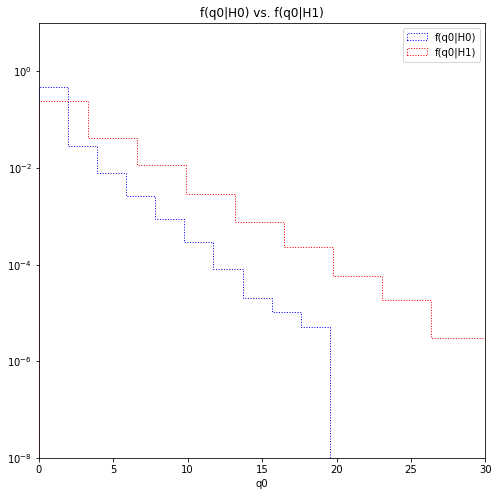

In [123]:
############################################
# Code 3-4: Plot the PDFs f(q|H0) and f(q|H1)
############################################


fig1, ax1 = plt.subplots(1,1,figsize=(8,8))
plt.title('f(q0|H0) vs. f(q0|H1)')
plt.xlim((0,30))
plt.ylim([10 ** -8, 10])
plt.xlabel('q0')
ax1.set_yscale('log')

plt.hist(q0_mc0, histtype='step', density=True, color='blue', linestyle='dotted', label='f(q0|H0)')
plt.hist(q0_mc1, histtype='step', density=True, color='red', linestyle='dotted', label='f(q0|H1)')

plt.legend(loc="upper right")
plt.show()

In [126]:
###########################################################
# Code 3-1: Generate samples under H0 hypothesis (mu=0)
###########################################################
length = len(mc_VBFSR) + len(mc_VBFCR)
Num = length
mu = 0 #the estimated factor for true event contribution (0 = assuming signals are all background)
s = S_MC #the amount of events assumed as signal
b, b_cr = B_MC, B_MC_CR #background in SR / background in CR
tau = b_cr/b #b_CR/b_SR

n0 = evt_gen(mu*s + b, Num) #a signal region sample under null hypothesis
m0 = evt_gen(tau*b, Num) #controlled (poisson distributed) sample (CR)

In [127]:
###########################################################
# Code 3-2: Generate samples under H1 hypothesis (mu=1)
###########################################################

Num = length
mu = 1 #the estimated factor for true event contribution (1 = assuming signals are all signal)
s = S_MC
b, b_cr = B_MC,B_MC_CR
tau = b_cr/b

n1 = evt_gen(mu*s + b, Num) #a signal region sample under alternate hypothesis
m1 = evt_gen(tau*b, Num)

In [128]:
###############################################################################
# Code 3-3: Calculate q0 for the generated samples under H0 and H1 respectively
###############################################################################

ticks_1 = time.time()
########################################################################################################################
#Define a vectorized function which takes a nested sequence of objects or numpy arrays as inputs and returns numpy array 
########################################################################################################################
q0_mc00 = np.vectorize(q0)(np.full(length,s),np.full(length,b),np.full(length,tau),n0,m0) #calculate q0 using generated sample under null hypothesis
q0_mc11 = np.vectorize(q0)(np.full(length,s),np.full(length,b),np.full(length,tau),n1,m1) #calculate q0 using generated sample under alternate hypothesis

#####################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min \033[0;m".format(totaltime/60.))

Time Cost : 5.2334 min 


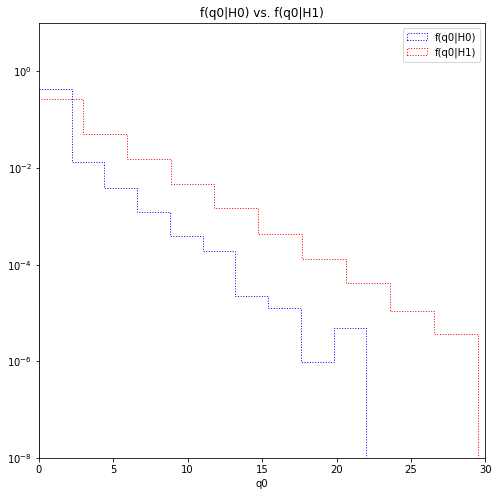

In [129]:
############################################
# Code 3-4: Plot the PDFs f(q|H0) and f(q|H1)
############################################


fig1, ax1 = plt.subplots(1,1,figsize=(8,8))
plt.title('f(q0|H0) vs. f(q0|H1)')
plt.xlim((0,30))
plt.ylim([10 ** -8, 10])
plt.xlabel('q0')
ax1.set_yscale('log')

plt.hist(q0_mc00, histtype='step', density=True, color='blue', linestyle='dotted', label='f(q0|H0)')
plt.hist(q0_mc11, histtype='step', density=True, color='red', linestyle='dotted', label='f(q0|H1)')

plt.legend(loc="upper right")
plt.show()

### Step 4: Calculate the p-value and significance

* p-value = probability to obtain $q_0 \geq q_0(observed)$  

In [124]:
########################################################
# Code 4-1:  Calculate the p-value and the significance
########################################################

# calculate q0(observed)
q0_obs = q0(s,b,tau,3051,11238)
print("q0_obs: ", q0_obs)

p0 = 0
for q_ in q0_mc0:
    if q_ >= q0_obs:
        p0 += 1
        
p0 /= len(q0_mc0)

significance = norm.ppf(1-p0)

print("p0: ", p0)
print("significance: ", significance)

q0_obs:  0.565474619193992
p0:  0.22511
significance:  0.7550483035289449


* sometimes we want to estimate the significance before obtaining the real data. In this case, we can take the median of q0 for f(q0|H1) to represent q_obs

In [125]:
##############################################################################
# Code 4-2:  Calculate the p-value and the significance with estimated q0_obs
##############################################################################

# calculate q0_median
q0_median = np.median(q0_mc1)
print("q0_median: ", q0_median)

p0 = 0
for q_ in q0_mc0:
    if q_ >= q0_median:
        p0 += 1
        
p0 /= len(q0_mc0)

significance = norm.ppf(1-p0)

print("p0: ", p0)
print("significance: ", significance)

q0_median:  0.8267993626086536
p0:  0.1808
significance:  0.9123205491470789


In [130]:
########################################################
# Code 4-1:  Calculate the p-value and the significance
########################################################

# calculate q0(observed)

q0_obs = q0(s,b,tau,B_DATA,B_DATA_CR)
print("q0_obs: ", q0_obs)

p0 = 0
for q_ in q0_mc00:
    if q_ >= q0_obs:
        p0 += 1
        
p0 /= len(q0_mc00)

significance = norm.ppf(1-p0)

print("p0: ", p0)
print("significance: ", significance)

q0_obs:  0.5859333530506772
p0:  0.1577093310741887
significance:  1.0039169161472663


In [131]:
##############################################################################
# Code 4-2:  Calculate the p-value and the significance with estimated q0_obs
##############################################################################

# calculate q0_median
q0_median = np.median(q0_mc11)
print("q0_median: ", q0_median)

p0 = 0
for q_ in q0_mc00:
    if q_ >= q0_median:
        p0 += 1
        
p0 /= len(q0_mc00)

significance = norm.ppf(1-p0)

print("p0: ", p0)
print("significance: ", significance)

q0_median:  0.8323919917947931
p0:  0.1577093310741887
significance:  1.0039169161472663


### Step 5: Asymptotic approximation

* Generating the pdf of test statistics is time-comsuming. Therefore, a method called "Asymptotic approximation" is commonly used to get the pdf instead of do sampling.

Here is the approximated form of f(q0|H(mu)):

$$f(q_0|\mu') =  \left( 1-\Phi \left(\frac{\mu'}{\sigma} \right) \right)\delta(q_0) + \frac{1}{2} \frac{1}{\sqrt{2\pi}} \frac{1}{\sqrt{q_0}} exp \left[ -\frac{1}{2} \left( \sqrt{q_0}-\frac{\mu'}{\sigma} \right)^2 \right ]$$

When $\mu'=0$, it can be reduced to

$$f(q_0|0) = \frac{1}{2}\delta(q_0) + \frac{1}{2} \frac{1}{\sqrt{2\pi}} \frac{1}{\sqrt{q_0}} e^{-q_0/2}$$

The $\sigma$ in the first equation can be computed by 

$$\sigma^2 = \frac{\mu'^2}{q_{0,A}} \text{  ,}$$

where $q_{0,A}$ means the $q_0$ calculated from the Asimov data.

Details about the asymptotic approximation can be found in ref[1].

### Asimov data

* A data point that is the representative of the whole generated dataset.

i.e. The data point with $n = \mu s + b$, $m = \tau b$

In [132]:
########################################################################################################
# Code 5-1: Construct the asymptotic functions
########################################################################################################

def delta(x,x_hat):
    if x == x_hat:
        return 1
    else:
        return 0


def get_q0A(mu, s, b, tau):
    return q0(s, b, tau, mu*s+b, b*tau)

#1. find the standard deviation
def sig(mu_p,s,b,tau):
    return mu_p/np.sqrt(get_q0A(mu_p, s, b, tau))

#2. Asymptotic formula
def pdf_asymptotic(q,mu_p,s,b,tau):
    if mu_p != 0:
        return (1-norm.cdf(mu_p/sig(mu_p,s,b,tau)))*delta(q,0) + 0.5/np.sqrt(2*np.pi)/np.sqrt(q)*np.exp(-0.5*(np.sqrt(q)-mu_p/sig(mu_p,s,b,tau))**2)
    else:
        return (8 * np.pi * q) ** -0.5 * np.exp(-0.5 * q)

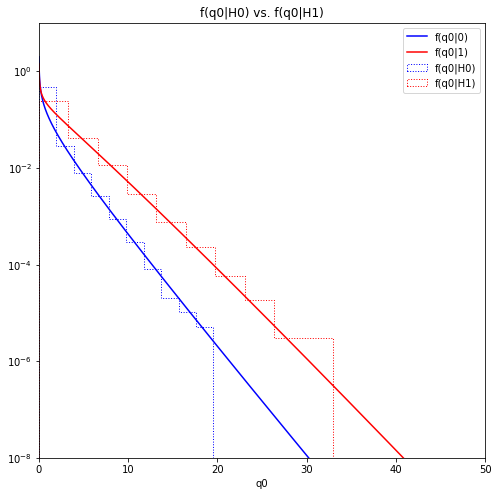

Time Cost : 0.0712 min 


In [133]:
########################################################################################################
# Code 5-2: Compare the pdfs from asymptotic approximation & sampling 
########################################################################################################

ticks_1 = time.time()
#####################

fig2, ax2 = plt.subplots(1,1,figsize=(8,8))
plt.title('f(q0|H0) vs. f(q0|H1)')
plt.xlim((0,50))
plt.ylim([10 ** -8, 10])
plt.xlabel('q0')
ax2.set_yscale('log')

plt.hist(q0_mc0, histtype='step', density=True, color='blue', linestyle='dotted', label='f(q0|H0)')
plt.hist(q0_mc1, histtype='step', density=True, color='red', linestyle='dotted', label='f(q0|H1)')

x = np.linspace(0.01, 50, 5000)
f_q0_mc0 = [pdf_asymptotic(q,0,s,b,tau) for q in x]
f_q0_mc1 = [pdf_asymptotic(q,1,s,b,tau) for q in x]

plt.plot(x, f_q0_mc0, color="blue", label='f(q0|0)')
plt.plot(x, f_q0_mc1, color="red", label='f(q0|1)')

plt.legend(loc="upper right")
plt.show()

#####################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min \033[0;m".format(totaltime/60.))

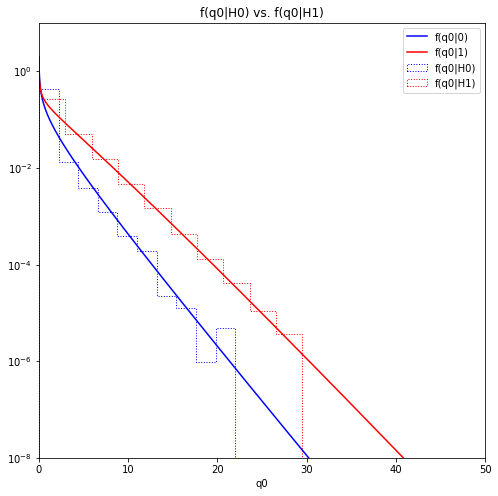

Time Cost : 0.0728 min 


In [134]:
########################################################################################################
# Code 5-2: Compare the pdfs from asymptotic approximation & sampling 
########################################################################################################

ticks_1 = time.time()
#####################
s = S_MC
b, b_cr = B_MC,B_MC_CR
tau = b_cr/b
fig2, ax2 = plt.subplots(1,1,figsize=(8,8))
plt.title('f(q0|H0) vs. f(q0|H1)')
plt.xlim((0,50))
plt.ylim([10 ** -8, 10])
plt.xlabel('q0')
ax2.set_yscale('log')

plt.hist(q0_mc00, histtype='step', density=True, color='blue', linestyle='dotted', label='f(q0|H0)')
plt.hist(q0_mc11, histtype='step', density=True, color='red', linestyle='dotted', label='f(q0|H1)')

x = np.linspace(0.01, 50, 5000)
f_q0_mc0 = [pdf_asymptotic(q,0,s,b,tau) for q in x]
f_q0_mc1 = [pdf_asymptotic(q,1,s,b,tau) for q in x]

plt.plot(x, f_q0_mc0, color="blue", label='f(q0|0)')
plt.plot(x, f_q0_mc1, color="red", label='f(q0|1)')

plt.legend(loc="upper right")
plt.show()

#####################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min \033[0;m".format(totaltime/60.))

In [136]:
########################################################################################################
# Code 5-3: Compare the p-values calculated from asymptotic approximation & sampling 
########################################################################################################
s = 56 #the amount of events assumed as signal
b, b_cr = 2905, 10866 #background in SR / background in CR
tau = b_cr/b #b_CR/b_SR

# calculate q0(observed)
q0_obs = q0(s,b,tau,3051,11238)

p0 = integrate.quad(pdf_asymptotic, q0_obs, np.inf, args=(0,s,b,tau))[0]
        
significance = norm.ppf(1-p0)
print("observed")
print("p0: ", p0)
print("significance: ", significance)

# calculate q0(median)
q0_median = np.median(q0_mc1)

p0 = integrate.quad(pdf_asymptotic, q0_median, np.inf, args=(0,s,b,tau))[0]
        
significance = norm.ppf(1-p0)
print("median")
print("p0: ", p0)
print("significance: ", significance)

# calculate q0(asimov)
q0_asimov = get_q0A(1, s, b, tau)

p0 = integrate.quad(pdf_asymptotic, q0_asimov, np.inf, args=(0,s,b,tau))[0]
        
significance = norm.ppf(1-p0)
print('asimov')
print("p0: ", p0)
print("significance: ", significance)

observed
p0:  0.22603140343714498
significance:  0.7519804646359283
median
p0:  0.18159983121038642
significance:  0.909285083243283
asimov
p0:  0.17895253970845693
significance:  0.9193642547776315


In [137]:
########################################################################################################
# Code 5-3: Compare the p-values calculated from asymptotic approximation & sampling 
########################################################################################################
s = S_MC
b, b_cr = B_MC,B_MC_CR
tau = b_cr/b

# calculate q0(observed)
q0_obs = q0(s,b,tau,B_DATA,B_DATA_CR)

p0 = integrate.quad(pdf_asymptotic, q0_obs, np.inf, args=(0,s,b,tau))[0]
        
significance = norm.ppf(1-p0)
print("observed")
print("p0: ", p0)
print("significance: ", significance)

# calculate q0(median)
q0_median = np.median(q0_mc11)

p0 = integrate.quad(pdf_asymptotic, q0_median, np.inf, args=(0,s,b,tau))[0]
        
significance = norm.ppf(1-p0)
print("median")
print("p0: ", p0)
print("significance: ", significance)

# calculate q0(asimov)
q0_asimov = get_q0A(1, s, b, tau)

p0 = integrate.quad(pdf_asymptotic, q0_asimov, np.inf, args=(0,s,b,tau))[0]
        
significance = norm.ppf(1-p0)
print("Asimov")
print("p0: ", p0)
print("significance: ", significance)

observed
p0:  0.2219979942242336
significance:  0.7654628358390452
median
p0:  0.18079088519199837
significance:  0.9123551894930413
Asimov
p0:  0.1789455067513279
significance:  0.9193911560470946
